In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
from openpyxl import load_workbook
from openpyxl import Workbook
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('tmdb_5000_movies.csv')
df.shape
filepath = 'tmdb_5000_empty.xlsx'
wb = load_workbook(filepath)
sheet = wb['Лист1']

In [3]:
print('{:>28}'.format('entries from dataset:'), df.shape[0])
df = df.drop_duplicates(['original_title'])
print('{:>28}'.format('entries without duplicated:'), df.shape[0])
df_clean = df[['budget', 'genres', 'release_date', 'revenue']].dropna()
print('{:>28}'.format('entries from cleaned data:'), df_clean.shape[0])

       entries from dataset: 4803
 entries without duplicated: 4801
  entries from cleaned data: 4800


In [4]:
df_genre = pd.DataFrame(columns = ['genre', 'cgenres', 'budget', 'revenue', 'day', 'month', 'year'])
#making function for definition every value of table (assign labels to indexes and colums)
def dataPrep(row):
    global df_genre
    d = {} #create an empty dictionary
    genres = np.array([g['name'] for g in eval(row['genres'])])
    n = genres.size
    d['budget'] = [row['budget']]*n
    d['revenue'] = [row['revenue']]*n
    d.update(zip(('year', 'month', 'day'), map(int, row['release_date'].split('-'))))
    d['genre'], d['cgenres'] = [], []
    for genre in genres:
        d['genre'].append(genre)
        d['cgenres'].append(genres[genres != genre])
    df_genre = df_genre.append(pd.DataFrame(d), ignore_index=True, sort=True)

df_clean.apply(dataPrep, axis=1)
df_genre = df_genre[['genre', 'budget', 'revenue', 'day', 'month', 'year', 'cgenres']] #renaming indexes
df_genre = df_genre.infer_objects()

In [5]:
df_clean[['genres', 'release_date']].head(2)

,genres,release_date
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",2009-12-10
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",2007-05-19


In [6]:
df_genre[['genre', 'cgenres', 'year']].head(7) #show certain colums till 7th row(6th index)

,genre,cgenres,year
0,Action,"[Adventure, Fantasy, Science Fiction]",2009
1,Adventure,"[Action, Fantasy, Science Fiction]",2009
2,Fantasy,"[Action, Adventure, Science Fiction]",2009
3,Science Fiction,"[Action, Adventure, Fantasy]",2009
4,Adventure,"[Fantasy, Action]",2007
5,Fantasy,"[Adventure, Action]",2007
6,Action,"[Adventure, Fantasy]",2007


In [7]:
print('{:>32}'.format('entries before data preparation:'), df_clean.shape[0])
print('{:>32}'.format('entries after data preparation:'), df_genre.shape[0])

entries before data preparation: 4800
 entries after data preparation: 12154


In [8]:
df_genre.head(10).T

,0,1,2,3,4,5,6,7,8,9
genre,Action,Adventure,Fantasy,Science Fiction,Adventure,Fantasy,Action,Action,Adventure,Crime
budget,237000000,237000000,237000000,237000000,300000000,300000000,300000000,245000000,245000000,245000000
revenue,2787965087,2787965087,2787965087,2787965087,961000000,961000000,961000000,880674609,880674609,880674609
day,10,10,10,10,19,19,19,26,26,26
month,12,12,12,12,5,5,5,10,10,10
year,2009,2009,2009,2009,2007,2007,2007,2015,2015,2015
cgenres,"[Adventure, Fantasy, Science Fiction]","[Action, Fantasy, Science Fiction]","[Action, Adventure, Science Fiction]","[Action, Adventure, Fantasy]","[Fantasy, Action]","[Adventure, Action]","[Adventure, Fantasy]","[Adventure, Crime]","[Action, Crime]","[Action, Adventure]"


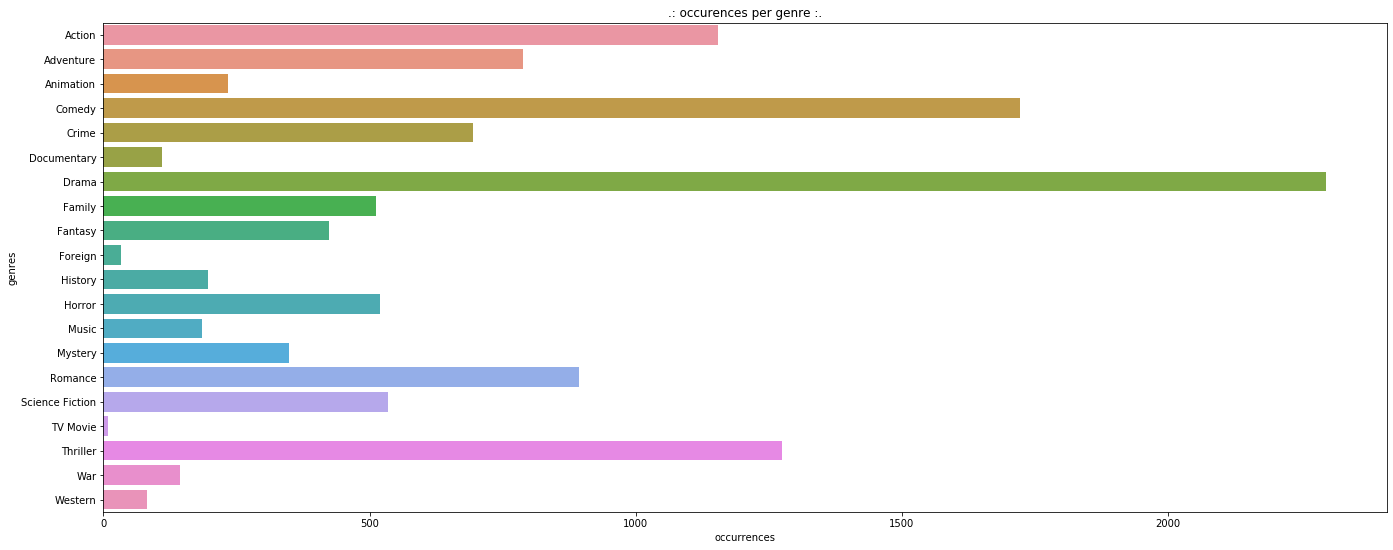

In [9]:
genre_count = df_genre['genre'].value_counts().sort_index()
df_gCount = pd.DataFrame({'genre': genre_count.index, 'count': genre_count.values})
f, ax = plt.subplots(figsize=(23, 9))
sns.barplot(x = 'count', y = 'genre', data=df_gCount)
ax.set_title('.: occurences per genre :.')
ax.set_xlabel('occurrences')
ax.set_ylabel('genres')
plt.show()

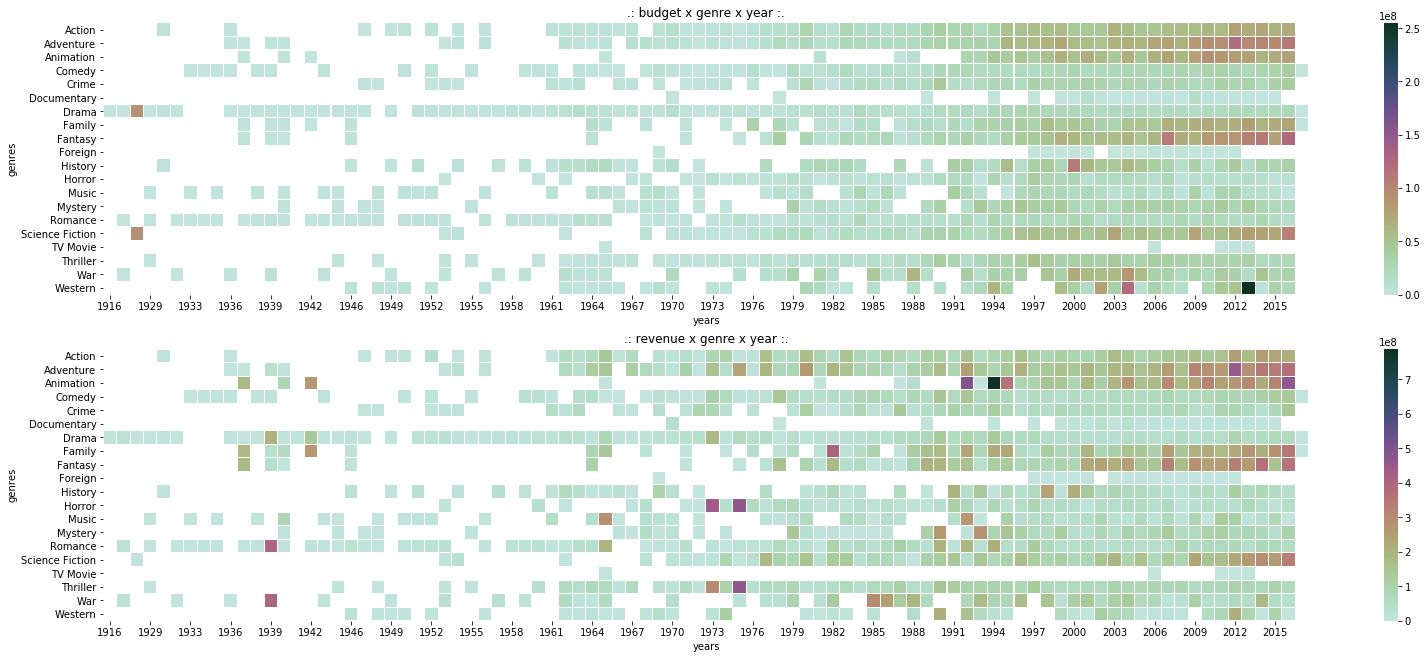

In [10]:
genre_year = df_genre.groupby(['genre', 'year']).mean().sort_index()
df_gyBudget = genre_year.pivot_table(index=['genre'], columns=['year'], values='budget', aggfunc=np.mean)
df_gyGross = genre_year.pivot_table(index=['genre'], columns=['year'], values='revenue', aggfunc=np.mean)
f, [axA, axB] = plt.subplots(figsize=(27, 11), nrows=2)
cmap = sns.cubehelix_palette(start=1.5, rot=1.5, as_cmap=True)
sns.heatmap(df_gyBudget, xticklabels=3, cmap=cmap, linewidths=0.05, ax=axA)
sns.heatmap(df_gyGross, xticklabels=3, cmap=cmap, linewidths=0.05, ax=axB)
axA.set_title('.: budget x genre x year :.')
axA.set_xlabel('years')
axA.set_ylabel('genres')
axB.set_title('.: revenue x genre x year :.')
axB.set_xlabel('years')
axB.set_ylabel('genres')
plt.show()

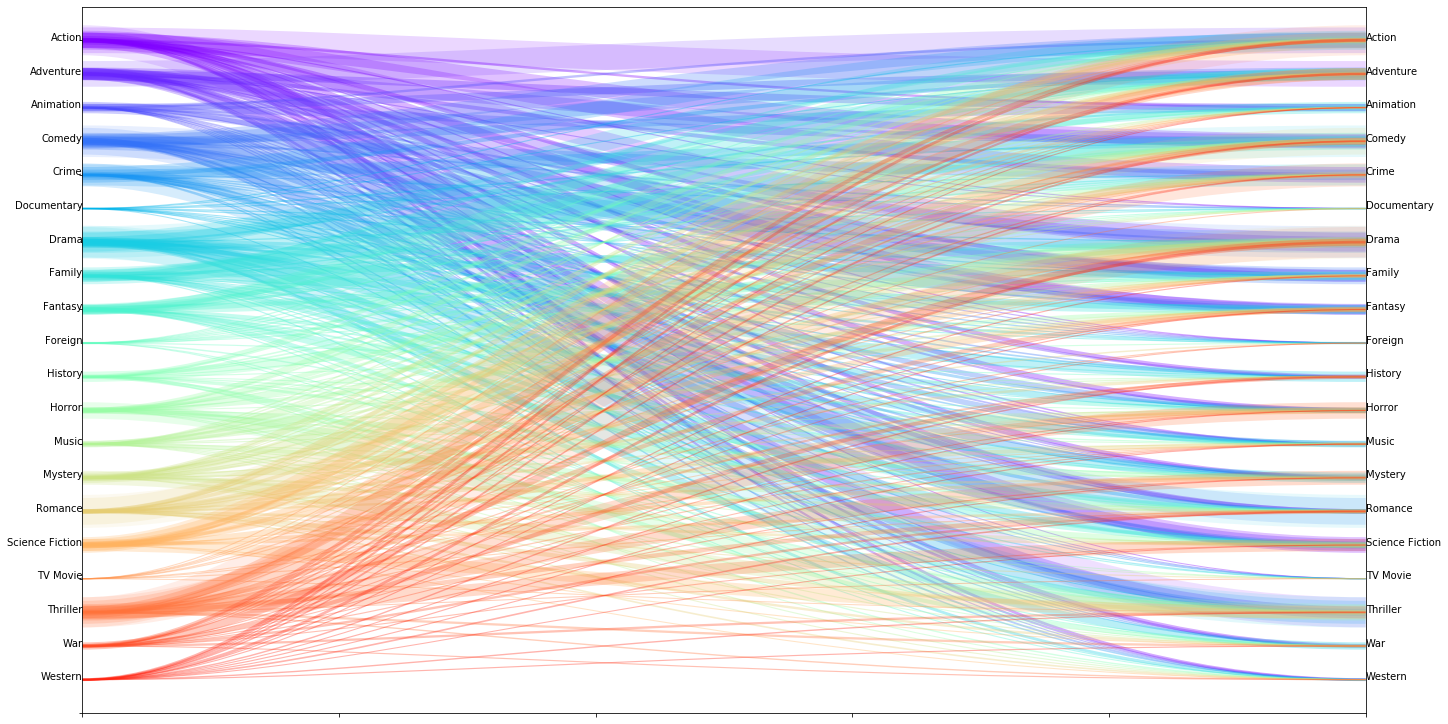

In [23]:
# make connections
d_genre = {}
def connect(row):
    global d_genre
    genre = row['genre']
    cgenres = row['cgenres']
    if genre not in d_genre:
        d_cgenres = dict(zip(cgenres, [1]*len(cgenres)))
        d_genre[genre] = d_cgenres
    else:
        for cgenre in cgenres:
            if cgenre not in d_genre[genre]:
                d_genre[genre][cgenre] = 1
            else:
                d_genre[genre][cgenre] += 1
                
df_genre.apply(connect, axis = 1)
l_genre = list(d_genre.keys())
l_genre.sort()

# find largest connection
cmax = 0
for key in d_genre:
    for e in d_genre[key]:
        if d_genre[key][e] > cmax:
            cmax = d_genre[key][e]
# visualize connections
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
color = cm.get_cmap('rainbow')
f, ax = plt.subplots(figsize = (23, 13))

codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]

fill_sep_row = 2
X, Y = 1, 1
wmin, wmax = 1, 32
amin, amax = 0.1, 0.25
getPy = lambda x: Y*(1 - x/len(l_genre))
for i, genre in enumerate(l_genre):
    yo = getPy(i) #y_output
    ax.text(0, yo, genre, ha = 'right')#left column of grafic, 0 - position of start
    ax.text(X, yo, genre, ha = 'left')#right column of grafic, x - temporary/present end of space
    for cgenre in d_genre[genre]:
        yi = getPy(l_genre.index(cgenre)) #y_input
        verts = [(0.0, yo), (X/4, yo), (2*X/4, yi), (X, yi)]
        path = Path(verts, codes)
        r, g, b, a = color(i/len(l_genre))#making a rainbow per genre
        width = wmin + wmax*d_genre[genre][cgenre]/cmax#assigning thickness depending on number of combination
        alpha = amin + amax*(1 - d_genre[genre][cgenre]/cmax)#assigning transpernty to rope per thickness (do not overlap other strings)
        patch = patches.PathPatch(path, facecolor = 'none', edgecolor = (r, g, b), lw = width, alpha = alpha) #assigning settings to each rope(string)
        #need to create inner iteration
        sheet.cell(row=fill_sep_row, column=1).value = width
        sheet.cell(row=fill_sep_row, column=2).value = (yo*10)*2
        sheet.cell(row=fill_sep_row, column=3).value = (yi*10)*2#filling Excel table with getting index of genre
        fill_sep_row += 1
        ax.add_patch(patch)

sheet.cell(row = 1, column = 1).value = 'Y'
sheet.cell(row = 1, column = 2).value = 'X0'
sheet.cell(row = 1, column = 3).value = 'X1'
sheet.delete_cols(5)#clearing column #5

ax.grid(False)
ax.set_xlim(0.0, X)
ax.set_ylim(0.0, Y + 1/len(l_genre))
ax.set_yticklabels([])
ax.set_xticklabels([])
wb.save(filepath)
plt.show()